## Importing Data

In [ ]:
# -*- coding: utf-8 -*-
# Regression Example With Boston Dataset: Standardized and Wider
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras import layers
from sklearn.utils import shuffle

import pandas as pd
import seaborn as sns
import keras
import keras.utils
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np

from mpl_toolkits import mplot3d
from cgi import test

dataset = pd.read_csv('aggregated_data.csv')


dataset = shuffle(dataset)
std_scaler = StandardScaler()


In [ ]:
def importData(data, scaler):

    train_dataset = data.sample(frac=0.8, random_state=9578)
    test_dataset = data.drop(train_dataset.index)

    train_features = train_dataset.copy()
    test_features = test_dataset.copy()

    train_labels = train_features.pop('Concentration')
    test_labels = test_features.pop('Concentration')

    train_features = scaler.fit_transform(train_features.to_numpy())
    dict = {
        'Time':train_features[:, 0], 
        'Current':train_features[:, 1], 
        'Spin Coating':train_features[:, 2] ,
        'Increaing PPM':train_features[:, 3], 
        'Temperature':train_features[:, 4], 
        'Repeat Sensor Use':train_features[:, 5], 
        'Days Elapsed':train_features[:, 6]
        }
    train_features = pd.DataFrame(dict)

    test_features = scaler.fit_transform(test_features.to_numpy())
    dict = {
        'Time':test_features[:, 0], 
        'Current':test_features[:, 1], 
        'Spin Coating':test_features[:, 2] ,
        'Increaing PPM':test_features[:, 3], 
        'Temperature':test_features[:, 4], 
        'Repeat Sensor Use':test_features[:, 5], 
        'Days Elapsed':test_features[:, 6]
        }
    test_features = pd.DataFrame(dict)

    #For later use
    data_labels = data.pop('Concentration')

    return data, data_labels, train_dataset, test_dataset, train_features, test_features, train_labels, test_labels, 
#sns.pairplot(train_dataset[['Time','Current', 'Spin Coating', 'Increasing PPM', 'Temperature', 'Repeat Sensor Use', 'Days Elapsed', 'Concentration']], diag_kind='kde')


# Neural Network Creation and Selection Process

### Functions: Build NN Model, Fit Model, K Cross Validation

In [49]:
def build_model(n1, n2, train_feats):
  #Experiment with different models, thicknesses, layers, activation functions; Don't limit to only 10 nodes; Measure up to 64 nodes in 2 layers
  model = keras.Sequential([
    layers.Dense(n1, activation=tf.nn.relu, input_shape=[len(train_feats.keys())]),
    layers.Dense(n2, activation=tf.nn.relu),
    layers.Dense(n2, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae','mse'])
  early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

  return model

def model_history(features, labels, model, epo, batch, vbs):
  
    history = model.fit(
        features, labels,
        epochs=epo, batch_size=batch, validation_split=0.2, verbose=vbs #, callbacks=early_stop
    )

    hist = pd.DataFrame(history.history)
    
    return hist

def KCrossValidation(i, features, labels, num_val_samples, epochs, batch, verbose, n1, n2):

    print('processing fold #', i)
    val_data = features[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = labels[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate([features[:i * num_val_samples], features[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([labels[:i * num_val_samples], labels[(i + 1) * num_val_samples:]],     axis=0)

    model = build_model(n1, n2, features)

    history = model_history(partial_train_data, partial_train_targets, model, epochs, batch, verbose)

    test_loss, test_mae, test_mse = model.evaluate(val_data, val_targets, verbose=1)

    return model, history, test_loss, test_mae, test_mse

## NEURAL NETWORK PARAMETERS

In [ ]:
all_features, data_labels, train_dataset, test_dataset, train_features, test_features, train_labels, test_labels,  = importData(dataset.copy(), std_scaler)
display(train_features)
k_folds = 5
num_val_samples = len(train_labels) // k_folds

n1_start = 10
n2_start = 10
sum_nodes = 23

num_epochs = 300
batch_size = 100
verbose = 0
avg_val_scores = []
order_of_architecture = []

all_networks  = []
all_history  = []
mae_history = []


##### Plotting Functions

In [ ]:
def plot_loss(history):

  plt.plot(history['loss'], label='loss')
  plt.plot(history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
  plt.show()

def correlation_plots(model, label, input_data, title, xlabel, ylabel):

  test_predictions = model.predict(input_data).flatten()
  plt.scatter(label,test_predictions)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.axis('equal')
  plt.axis('square')
  plt.grid(True)
  plt.show()
  return test_predictions


def plotGraph(y_test, y_pred,regressorName):
    plt.scatter(range(len(y_pred)), y_test, color='blue')
    plt.scatter(range(len(y_pred)), y_pred, color='red')
    plt.title(regressorName)
    plt.show()
    return


#### Where the Magic Happens

In [56]:
#(TAKEN FROM DEEP LEARNING WITH PYTHON BY MANNING)
for i in range(n1_start, sum_nodes):

    for j in range(n2_start, sum_nodes):
        if (i+j > sum_nodes):
            continue
        
        print("first hidden layer", j)
        print("second hidden layer", i)
        k_fold_test_scores = []
        k_models = []
        k_history = []

        k_mae_history = []

        for fold in range(k_folds):
            model, history, test_loss, test_mae, test_mse = KCrossValidation(
                fold, 
                train_features, 
                train_labels, 
                num_val_samples, 
                num_epochs, 
                batch_size, 
                verbose, 
                j, 
                i)

            #plot_loss(history)
            k_fold_test_scores.append(test_mae)
            k_history.append(history)
            k_models.append(model)
            k_mae_history.append(history['val_mae'])


        avg_val_scores.append(sum(k_fold_test_scores)/len(k_fold_test_scores))
        all_history.append(k_history)
        all_networks.append(k_models)

        
        mae_history.append([ np.mean([x[i] for x in k_mae_history]) for i in range(num_epochs)])


        order_of_architecture.append([i, j])


       #test_predictions = correlation_plots(model, test_labels, test_features, "Testing Correlation Plot", "Actual", "Predicted")
        #plotGraph(test_labels, test_predictions, "Testing Plot")


        #training_predictions = correlation_plots(model, train_labels, train_features, "Training Correlation Plot", "Actual", "Predicted")
        #plotGraph(train_labels, training_predictions, "Training Plot")

# Find the model with the lowest error
lowest_index = avg_val_scores.index(min(avg_val_scores))
optimal_NNs = all_networks[lowest_index]

print(avg_val_scores)

#print(mae_history)
# Find the history of that model, and display it
for i in range(k_folds):
    x = all_history[lowest_index][i]['val_mae']




first hidden layer 10
second hidden layer 10
processing fold # 0
102/102 [==============================] - 0s 1ms/step - loss: 0.5741 - mae: 0.4623 - mse: 0.5741
processing fold # 1
102/102 [==============================] - 0s 1ms/step - loss: 0.3800 - mae: 0.3993 - mse: 0.3800
processing fold # 2
102/102 [==============================] - 0s 1ms/step - loss: 0.4902 - mae: 0.3890 - mse: 0.4902
first hidden layer 11
second hidden layer 10
processing fold # 0
102/102 [==============================] - 0s 1ms/step - loss: 0.4554 - mae: 0.3922 - mse: 0.4554
processing fold # 1
102/102 [==============================] - 0s 1ms/step - loss: 0.2978 - mae: 0.3319 - mse: 0.2978
processing fold # 2
102/102 [==============================] - 0s 1ms/step - loss: 0.3737 - mae: 0.3335 - mse: 0.3737
first hidden layer 12
second hidden layer 10
processing fold # 0


Plotting Loss Transition

[10, 13]


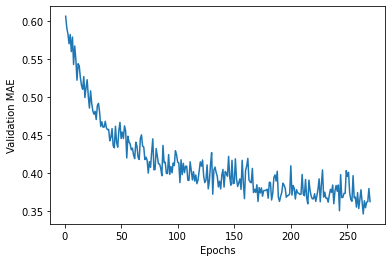

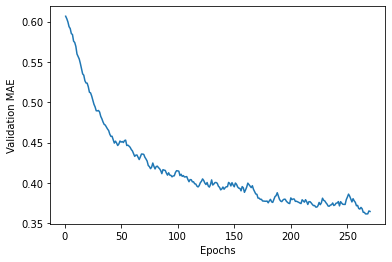

In [ ]:
from operator import index


def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

print(order_of_architecture[lowest_index])
plt.plot(range(1, len(mae_history[lowest_index][int(num_epochs/10):]) + 1), mae_history[lowest_index][int(num_epochs/10):])
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

smooth_mae_history = smooth_curve(mae_history[lowest_index][int(num_epochs/10):])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()




# Isolating Parameters and Printing them Out

Scaling Data Set Function

In [51]:
def scaleDataset(data):
    data = std_scaler.fit_transform(data.to_numpy())
    dict = {
        'Time':data[:, 0], 
        'Current':data[:, 1], 
        'Spin Coating':data[:, 2] ,
        'Increaing PPM':data[:, 3], 
        'Temperature':data[:, 4], 
        'Repeat Sensor Use':data[:, 5], 
        'Days Elapsed':data[:, 6]
        }
    return pd.DataFrame(dict)


## Functions for Isolating Parameters

In [ ]:
def IsolateBinaryTime(data, parameter, start_time, batch, vbs):
    # Splitting Spin Coating, then seperating by time

    ss_1 = np.where(data[parameter].to_numpy()  ==  1)[0]
    ss_0 = np.where(data[parameter].to_numpy()  ==  0)[0]

    times_index = []
    times_0 = []

    shared_time_1 = []
    shared_time_0 = []

    for i in range(0, 51):
        times_index.append(np.where(data['Time'].to_numpy()  == i)[0].tolist())

        time_1_tmp = []
        time_0_tmp = []
        
        for index_sc in ss_1:
            if index_sc in times_index[i]:
                time_1_tmp.append(index_sc)
        for index_sc in ss_0:
            if index_sc in times_index[i]:
                time_0_tmp.append(index_sc)
                
        shared_time_1.append(time_1_tmp)
        shared_time_0.append(time_0_tmp)

    scaled_features = scaleDataset(all_features.copy())

    shared_features = []
    shared_labels = []

    for i in range(0, 51):
        shared_features.append([
            scaled_features.iloc[shared_time_0[i]], 
            scaled_features.iloc[shared_time_1[i]]
            ])
            
        shared_labels.append([
            data_labels.to_numpy()[shared_time_0[i]], 
            data_labels.to_numpy()[shared_time_1[i]]
            ])


    shared_mae = []
    for i in range(start_time, 51):
        sc_tmp_mae = []

        for j in range(0, 2):
            tmp_mae = []
            #print("TIME = ", i, "S", "SPINCOATED = ", j)

            for NN in optimal_NNs:
                test_loss, test_mae, test_mse = NN.evaluate(
                    shared_features[i][j], 
                    shared_labels[i][j],
                    batch_size=batch,  
                    verbose=vbs
                    )
                tmp_mae.append(test_mae)

                    
            shared_predictions = correlation_plots(
                NN, shared_labels[i][j], 
                shared_features[i][j].to_numpy(),  
                "Testing Correlation Plot for Shared " + str(j) + " at time: " + str(i), 
                "Actual", "Predicted"
                )

            #plotGraph(shared_labels[i][j], shared_predictions, "Shared Plot")

            sc_tmp_mae.append(tmp_mae)
        shared_mae.append(sc_tmp_mae)

    mins = []
    averages = []
    for i in shared_mae:
        mins.append([min(i[0]), min(i[1])])
        averages.append([sum(i[0])/len(i[0]), sum(i[1])/len(i[1])])

    return mins, averages, shared_mae, 

In [ ]:
def isolateParam(data, parameter, start_index, end_index, NN_start, batch, verbose):
    # Split the data labels with time
    param_index= []
    for i in range(start_index, end_index):
        param_index.append(np.where(data[parameter].to_numpy()  == i)[0])

        
    scaled_features = scaleDataset(all_features.copy())
    #The full features of the data points that use certain time values
    param_features = []
    param_labels = []

    for i in range(start_index, end_index):
        param_features.append(scaled_features.iloc[param_index[i]])
        #The stupid labels for each second
        param_labels.append(data_labels.to_numpy()[param_index[i]])


    mae = []
    for i in range(NN_start, end_index):
        tmp_mae = []
        #print("TIME = ", i, "S")
        for NN in optimal_NNs:
            test_loss, test_mae, test_mse = NN.evaluate(
                param_features[i], 
                param_labels[i], 
                batch_size=batch,  
                verbose=verbose
                )
            tmp_mae.append(test_mae)

            
            _predictions = correlation_plots(
                NN, 
                param_labels[i], 
                param_features[i], 
                "Testing Correlation Plot for Time " + str(i), "Actual", 
                "Predicted"
                )
            #plotGraph(param_labels[i], _predictions, "Time Plot")

        mae.append(tmp_mae)

    mins = []
    averages = []
    for i in mae:
        mins.append(min(i))
        averages.append(sum(i)/len(i))

    return mins, averages, mae


#### Isolating Spin Coating

In [ ]:
mins_sc, averages_sc, mae_sc = isolateParam(dataset, 'Spin Coating', 0, 2, 0, 10, 1)
print(mins_sc)
print(averages_sc)


#### Isolating Time

In [ ]:
NN_start_time = 10
mins_time, averages_time, mae_time = isolateParam(dataset, 'Time', 0, 51, 1, NN_start_time, 1)

In [ ]:
plt_tmp = []
for i in averages_time:
    plt_tmp.append(i)
    
for i in range(len(mins_time)):
    print(mins_time[i], averages_time[i])

plt.plot(range(NN_start_time, len(averages_time) +NN_start_time), plt_tmp)
plt.xlabel('Time (s)')
plt.ylabel('Mean Absolute Error')

#### Isolating Spin Coating and Time

In [ ]:
verbose_isolate = 0
mins_sct, averages_sct, shared_sct = IsolateBinaryTime(dataset, 'Spin Coating', 15, 10, verbose_isolate)

In [ ]:
plt_tmp_1 = []
plt_tmp_0 = []

for i in averages_sct:
    plt_tmp_1.append(i[1])
    plt_tmp_0.append(i[0])

for i in range(len(mins_sct)):
    print(mins_sct[i], averages_sct[i])

plt.plot(range(15, len(averages_sct) +15), plt_tmp_1)
plt.plot(range(15, len(averages_sct) +15), plt_tmp_0)
plt.xlabel('Time (s)')
plt.ylabel('Mean Absolute Error')

#### Isolating Increasing PPM and Time

In [ ]:
verbose_isolate = 1
start_t_increasing = 15
mins_increasing, averages_increasing, shared_increasing = IsolateBinaryTime(dataset, 'Increasing PPM', start_t_increasing, 10, verbose_isolate)

In [ ]:
plt_tmp_1 = []
plt_tmp_0 = []
for i in averages_increasing:
    plt_tmp_1.append(i[1])
    plt_tmp_0.append(i[0])

for i in range(len(mins_increasing)):
    print(mins_increasing[i], averages_increasing[i])

plt.plot(range(start_t_increasing, len(averages_increasing) +start_t_increasing), plt_tmp_1)
plt.plot(range(start_t_increasing, len(averages_increasing) +start_t_increasing), plt_tmp_0)
plt.xlabel('Time (s)')
plt.ylabel('Mean Absolute Error')

#### Repeat Sensor Use

In [ ]:
# Split the data labels with RSU
repeat_index= []
for i in range(1, 4):
    repeat_index.append(np.where(dataset['Repeat Sensor Use'].to_numpy()  == i)[0])

shared_tr_1 = []
shared_tr_2 = []
shared_tr_3 = []

times_index = []
for i in range(0, 51):
    times_index.append(np.where(dataset['Time'].to_numpy()  == i)[0].tolist())

    tr_1_tmp = []
    tr_2_tmp = []
    tr_3_tmp = []

    for j in range(len(repeat_index)):
   
        for index_123 in repeat_index[j]:

            if index_123 in times_index[i] and j == 0:
                tr_1_tmp.append(index_123)
            elif index_123 in times_index[i] and j == 1:
                tr_2_tmp.append(index_123)
            elif index_123 in times_index[i] and j == 2:
                tr_3_tmp.append(index_123)

#            time_0_tmp.append(index_sc)
        

    shared_tr_1.append(tr_1_tmp)
    shared_tr_2.append(tr_2_tmp)
    shared_tr_3.append(tr_3_tmp)

scaled_features = scaleDataset(all_features.copy())
#The full features of the data points that use certain time values
tr_features = []
tr_labels = []


for i in range(0, 51):
    tr_features.append([
        scaled_features.iloc[shared_tr_1[i]], 
        scaled_features.iloc[shared_tr_2[i]], 
        scaled_features.iloc[shared_tr_3[i]]
        ])

    tr_labels.append([
        data_labels.to_numpy()[shared_tr_1[i]], 
        data_labels.to_numpy()[shared_tr_2[i]], 
        data_labels.to_numpy()[shared_tr_3[i]]
        ])

tr_mae = []
for i in range(15, 51):
    tr_tmp_mae = []

    for j in range(0, 3):

        tmp_mae = []
        
        for NN in optimal_NNs:
            test_loss, test_mae, test_mse = NN.evaluate(tr_features[i][j], tr_labels[i][j], batch_size=2,  verbose=0)
            tmp_mae.append(test_mae)

            #repeat_predictions = correlation_plots(NN, repeat_labels[i], repeat_features[i], "Testing Correlation Plot for RSU " + str(i), "Actual", "Predicted")
            #plotGraph(RSU_labels[i], RSU_predictions, "RSU Plot")

        tr_tmp_mae.append(tmp_mae)
    tr_mae.append(tr_tmp_mae)





In [ ]:
mins_tr = []
averages_tr = []
for i in tr_mae:
    mins_tr.append([min(i[0]), min(i[1]), min(i[2])])
    averages_tr.append([sum(i[0])/len(i[0]), sum(i[1])/len(i[1]), sum(i[2])/len(i[2])])



plt_tmp_1 = []
plt_tmp_2 = []
plt_tmp_3 = []

for i in averages_tr:
    plt_tmp_1.append(i[0])
    plt_tmp_2.append(i[1])
    plt_tmp_3.append(i[2])


#for i in range(len(tr_mae)):
#    print(mins[i], averages[i])

plt.plot(range(15, len(averages_increasing) +15), plt_tmp_1, label = "Day 1")
plt.plot(range(15, len(averages_increasing) +15), plt_tmp_2, label = "Day 2")
plt.plot(range(15, len(averages_increasing) +15), plt_tmp_3, label = "Day 3")

plt.xlabel('Time (s)')
plt.ylabel('Mean Absolute Error')
plt.legend()

#for j in range(0, len(tr_mae)):
#    print(mins[j], averages[j])
